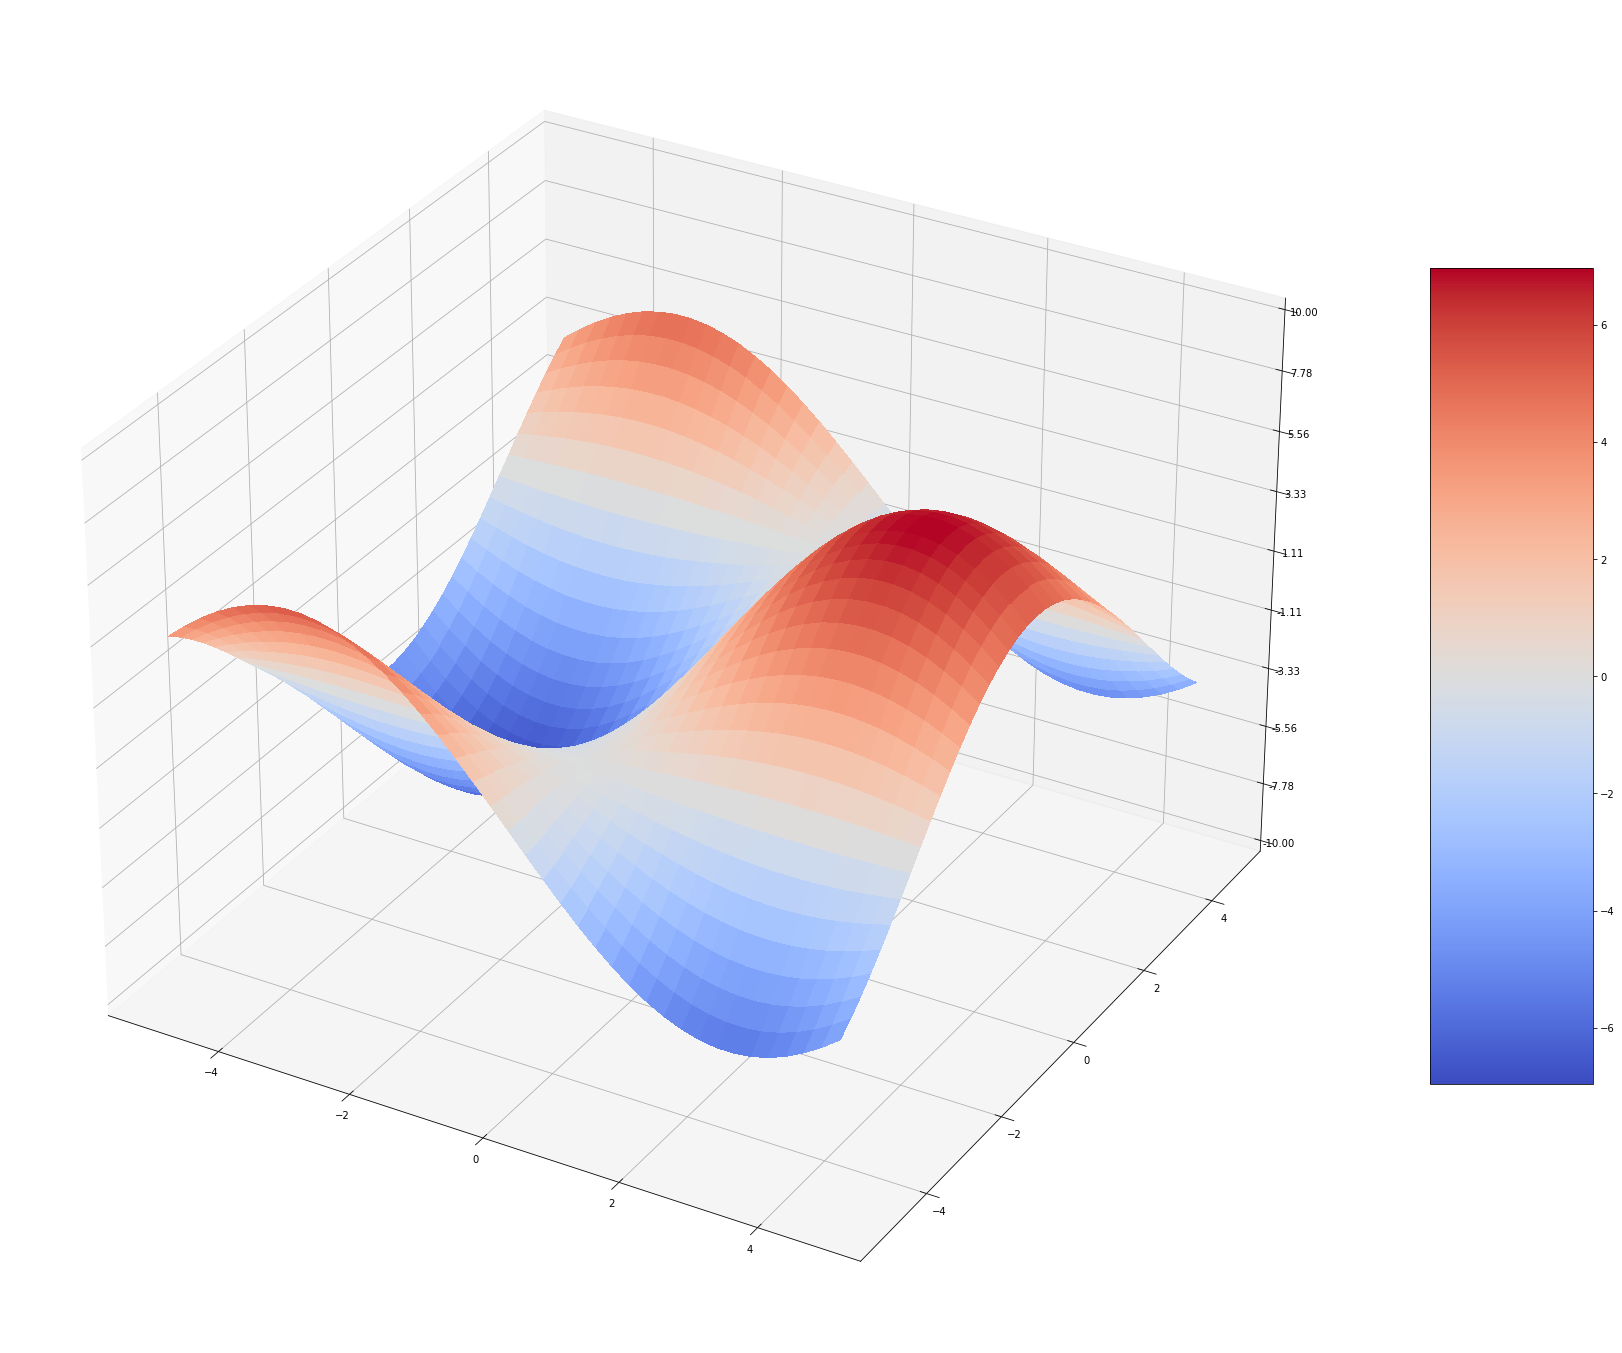

In [1]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import numpy.matlib as matlib
import math
import random
from tqdm import tqdm

scale = 8
h = 1.5

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(30,30))
# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)


X, Y = np.meshgrid(X, Y)
Z = 7*np.sin(X/2)*np.cos(Y/2)


H = [X.flatten(), Y.flatten(), Z.flatten()]
H = np.array(H)




R = H.copy()
# R = np.transpose(R)
err = 0.2 * np.ones_like(R)
R = np.random.normal(R, err)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#sub_plot = ax.scatter(R[0,:], R[1,:], R[2,:], c="blue")
# Customize the z axis.
ax.set_zlim(-10, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
fig.savefig('Original.png')


In [2]:

def Spatial_weighted_PCA(X, q, d=2,h = 2):
    R = np.array(X, copy=True)

    """
    Goal:Find U˜d is of the matrix containing the first d principal components of the matrix A˜
    
    Input:
    X is an (n,N) matrix, col-i(X) is a vector xi, 
    q is a vector whcih consider as an anchor to compute spatial weight
    d:select first d principal components of the matrix X˜

    Output:
    U˜d U˜d.T, where U˜d is the matrix containing the first d principal components of the matrix X˜
    """
    for i in range(R.shape[1]):  # iterate through each vector to multiply spatial weight
        r = np.linalg.norm(R[:, i] - q)
        R[:, i] *=  math.sqrt(math.exp(-(r*r/(h*h))))

    U, Sigma, Vh = np.linalg.svd(R, full_matrices=False)

    return U[:, :d]



In [3]:


def AlgorithmOne(R, r, h, episilon):
    """
    Input:
    R ∈ n by N matrix, col-i(R) is a vector ri, ri is also an sample neighbor of r
    r:consider such point to perform MMLS
    """

    q = r
    U = Spatial_weighted_PCA(R, q)

    R_neighbors_proj = np.matmul(np.matmul(U, U.T), R)
    r_proj = np.matmul(np.matmul(U, U.T), r)

    while True:
        q_prev = q
        R_telta = R - matlib.repmat(np.expand_dims(q, axis=1), 1, R.shape[1])
        diag_element = []
        for i in range(R_telta.shape[1]):
          d = np.linalg.norm(R[:, i] - q)
          diag_element.append(math.sqrt(math.exp(-(d*d/(h*h)))))


        Theta = np.diag(np.asarray(diag_element))
        R_telta = np.matmul(R_telta, Theta)
        X = np.matmul(R_telta.T, U)

        new_col = np.ones(X.shape[0])

        X_telta = np.insert(X, 0, new_col, axis=1)

        alpha, _, _, _ = np.linalg.lstsq(a=np.matmul(X_telta.T, X_telta), b=np.matmul(X_telta.T, R_telta.T), rcond=None)

        q_telta = q + alpha[0, :]

        Q, R_hat = np.linalg.qr(alpha[1:, :].T)
        U = Q

        q = q_telta + np.matmul(np.matmul(U, U.T), (r - q_telta))

        dist = np.linalg.norm(q - q_prev)
        # print(f"dist {dist}, q{q}, q_perv{q_prev}")

        if dist < episilon:
            break

    return U, q



In [4]:
def polynomial_basis(point, m):
    x, y = point
    basis = []
    for deg_x in range (m+1):
        for deg_y in range (0, m-deg_x+1):
            print(deg_x, deg_y)
            basis.append(x**deg_x * y**deg_y)
    # return np.array([1, x, x * x, y, y * y, x * y])
    return np.array(basis)

In [5]:
def polynomial_basis(point, m):
    x, y = point
    basis = []
    for deg_x in range (m+1):
        for deg_y in range (0, m-deg_x+1):
            basis.append(x**deg_x * y**deg_y)
    return np.array(basis)

def AlgorithmTwo(R, U, r, q, m, h = 0.5):
    dist = [np.linalg.norm(p_i - q) for p_i in R.T]
    theta = np.array([math.sqrt(math.exp(-(d*d/(h*h)))) for d in dist])

    n = (r-q) / np.linalg.norm(r - q)
    f_i = np.array([(p_i - q) @ n for p_i in R.T])
    
    R_telta = R - matlib.repmat(np.expand_dims(q, axis=1), 1, R.shape[1])
    X = np.matmul(R_telta.T, U)
    basis_order = (m+1)*(m+2)//2
    pol_basis = np.ones((basis_order, R.shape[1]))

    for i in range(len(R.T)):
      pol_basis[:, i] = polynomial_basis(X[i], m)

    Theta = np.diag(theta)

    A = pol_basis @ Theta @ pol_basis.T
    B = pol_basis @ Theta @ f_i

    poly_coef, _, _, _ = np.linalg.lstsq(A, B)

    # print("poly_coef",poly_coef.shape)

    p_m = poly_coef @ pol_basis

    proj_point = np.array([n * p_i for p_i in matlib.repmat(p_m, 3, 1).T])

    return proj_point


# =============================================================================
#         //預先計算多項式的各項
#         //如果order為2, P(:, ni) = [1, v, v^2, u, uv, u*2]
#         // Compute the polynomial's terms at the current point
#         int j = 0;
#         double u_pow = 1;
#         for (int ui = 0; ui <= order; ++ui)
#         {
#           double v_pow = 1;
#           for (int vi = 0; vi <= order - ui; ++vi)
#           {
#             //j:多項式的第幾項
#             //u_pow:動態更新,為u_coord的ui次方
#             //v_pow:動態更新,為v_coord的ui次方
#             P (j++, ni) = u_pow * v_pow;
#             v_pow *= v_coord;
#           }
#           u_pow *= u_coord;
#         }
#       }
# =============================================================================


# [1,x,y][][1 *x * y]

In [6]:



def Affine_sub_space_modified( r, R, h, m):
    """
    goal : 用r附近的點(eg.B(r,1))做subspace fitting

    Input: n ∈ N, r ∈ R ⊆ R^N be a fnite set
    Output: neighbors of r being projected to column space of U

    """
    dist_to_all =  [np.linalg.norm(np.array(R[:, i]) - np.array(r)) for i in range(R.shape[1])]
    
    neighbors_index = []
    dist_to_neighbors = []
    for i,dist in enumerate(dist_to_all):
      if dist<2:
        neighbors_index.append(i)
        dist_to_neighbors.append(dist)
      
    neighbors_index =[i for _,i in sorted(zip(dist_to_neighbors,neighbors_index))]
    R_neighbors = [R[:, i] for i in neighbors_index]

    # print("R_neighbors:",len(R_neighbors))



    # R_neighbors = [R[:, i] for i in range(R.shape[1]) if np.linalg.norm(np.array(R[:, i]) - np.array(r)) < 2]
    
    R_neighbors = np.asarray(R_neighbors)
    R_neighbors = np.transpose(R_neighbors)

    U, q = AlgorithmOne(R_neighbors, r, h, episilon=1e-2)

    # print("U",U.shape)
    R_telta = R_neighbors - matlib.repmat(np.expand_dims(q, axis=1), 1, R_neighbors.shape[1])

    neighbors_len = len(R_neighbors.T)

    # Project neighbors of one ball onto H
    R_neighbors_proj = np.matmul(np.matmul(U, U.T), R_telta)
    
    R_neighbors_proj_surface = AlgorithmTwo(R_neighbors, U, r, q, m, h).T

    # print("R_neighbors_proj",R_neighbors_proj.shape)
    # print("R_neighbors_proj_surface",R_neighbors_proj_surface.shape)
    # print("Center",matlib.repmat(r, neighbors_len, 1).T.shape)

    surface_fit = (R_neighbors_proj + R_neighbors_proj_surface + matlib.repmat(r, neighbors_len, 1).T )

    return surface_fit




In [7]:
sample_index = np.random.randint(low=0, high=R.shape[1], size=400, dtype=int)


#Noisy sample assumption

In [8]:
from numpy import linalg as LA
error = LA.norm(H.T-R.T,axis=1)
E_original = np.power(error, 2).mean()
print(f"mean_error:{E_original}")

mean_error:0.12167465153160859


  0%|          | 0/400 [00:00<?, ?it/s]/var/folders/5x/836ygdnj2yl_4txj_vrwx_740000gn/T/ipykernel_82288/1383172910.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  poly_coef, _, _, _ = np.linalg.lstsq(A, B)
100%|██████████| 400/400 [00:08<00:00, 45.66it/s]


8.644231000000001


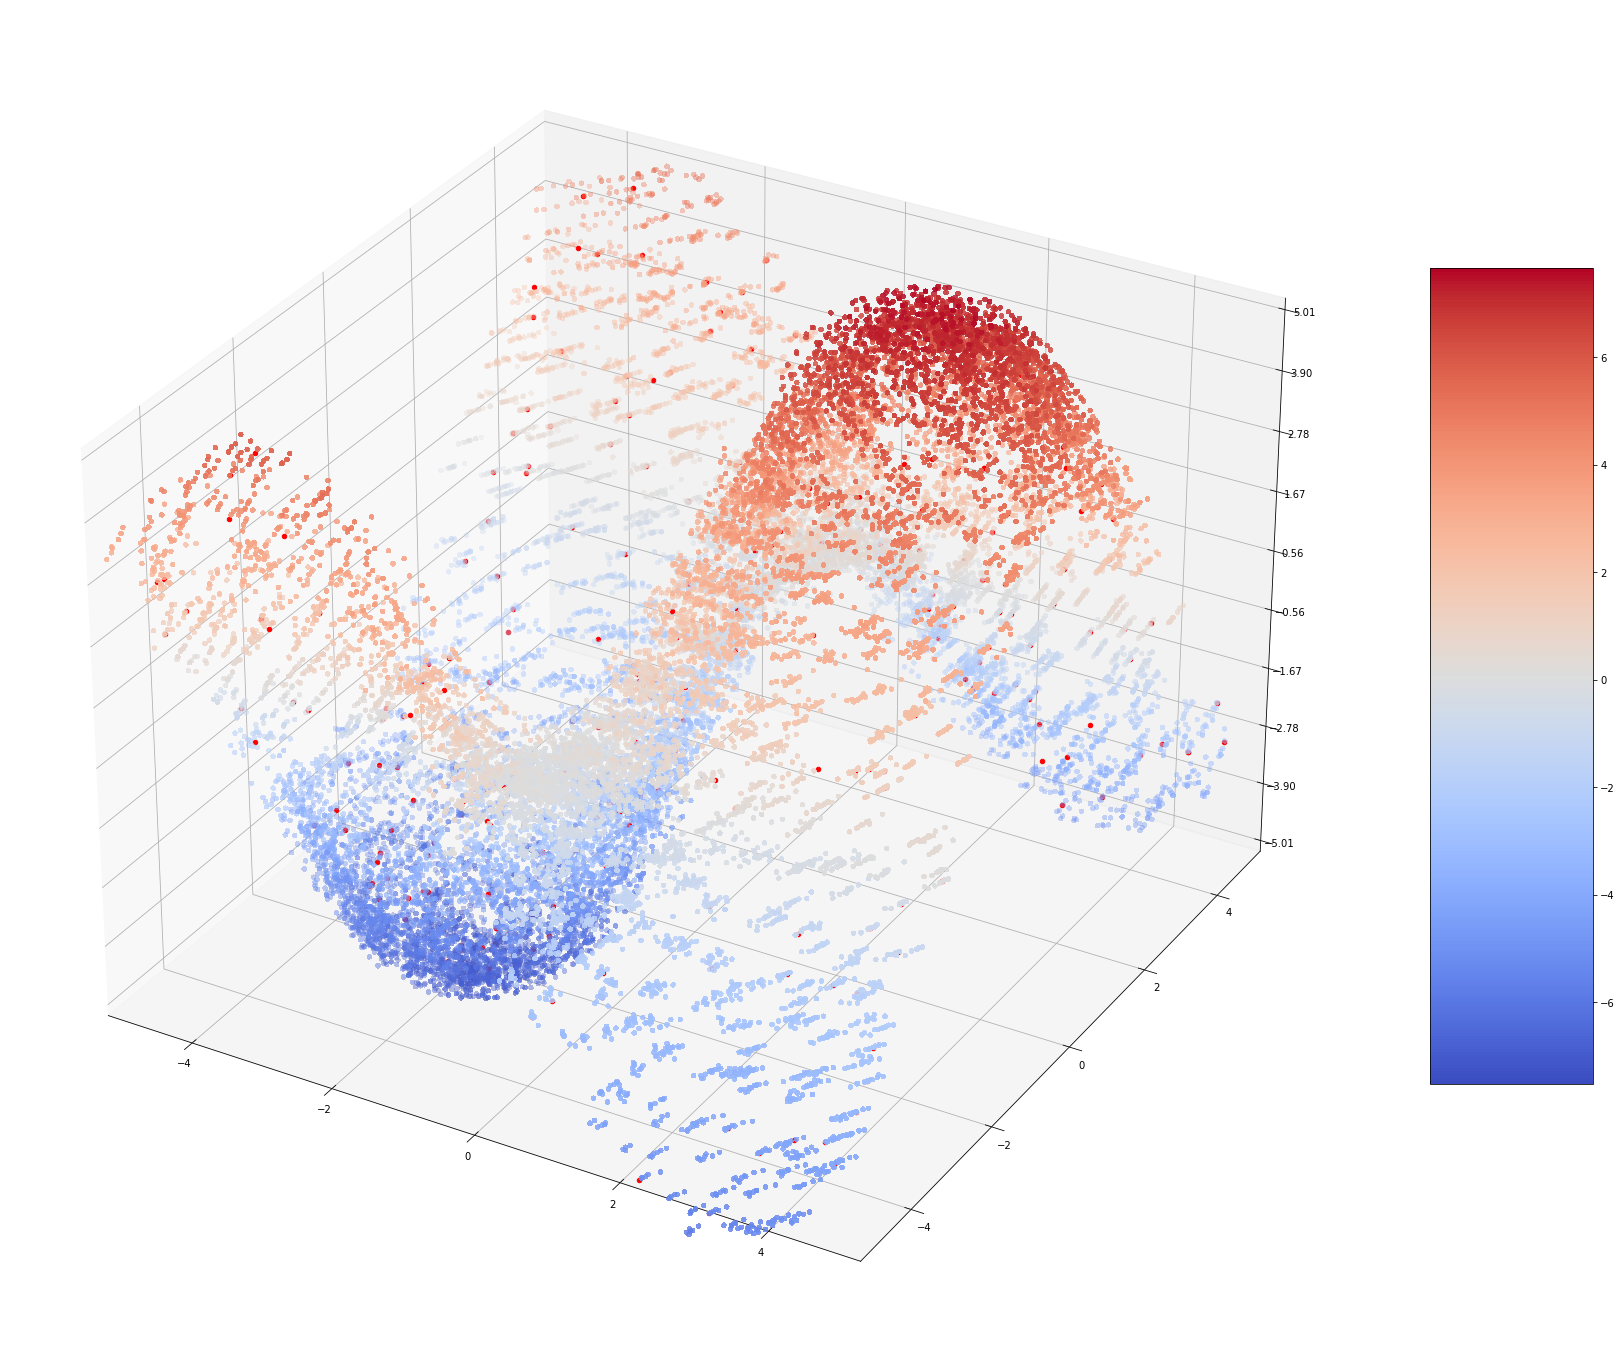

In [9]:
import time
# 隨機選 size 個點

# original_sample_points = [H[:,i] for i in sample_index]
reconstruct_sample_points_2 = []


fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(30, 30))


sub_x_all = []
sub_y_all = []
sub_z_all = []

start = time.process_time()
for index in tqdm(sample_index):

  # print(f"index:{index}")
  r = R[:, index]

  # print("r",r.shape)

  ax.scatter(*r, c="red")

  R_neighbors_project_2 = Affine_sub_space_modified( r, R, h=1.5, m=2)
  # print(np.linalg.norm(q-r))

  sub_x, sub_y, sub_z = R_neighbors_project_2

  reconstruct_sample_points_2.append(R_neighbors_project_2[:,0])

  # sub_plot = ax.scatter(sub_x, sub_y, sub_z, c="blue")
  
  sub_x_all.extend(sub_x)
  sub_y_all.extend(sub_y)
  sub_z_all.extend(sub_z)
print(f"{time.process_time() - start}")

reconstruc_surf = ax.scatter(sub_x_all, sub_y_all, sub_z_all, c=sub_z_all,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, 40)

# Add a color bar which maps values to colors.


ax.set_xlim(-5.01, 5.01)
ax.set_ylim(-5.01, 5.01)

# Customize the z axis.
ax.set_zlim(-5.01, 5.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{02f}.format(x)')

# Add a color bar which maps values to colors.
fig.colorbar(reconstruc_surf, shrink=0.5, aspect=5)
plt.show()
fig.savefig('Result.png')


  0%|          | 0/400 [00:00<?, ?it/s]/var/folders/5x/836ygdnj2yl_4txj_vrwx_740000gn/T/ipykernel_82288/1383172910.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  poly_coef, _, _, _ = np.linalg.lstsq(A, B)
100%|██████████| 400/400 [00:09<00:00, 42.42it/s]


9.275607


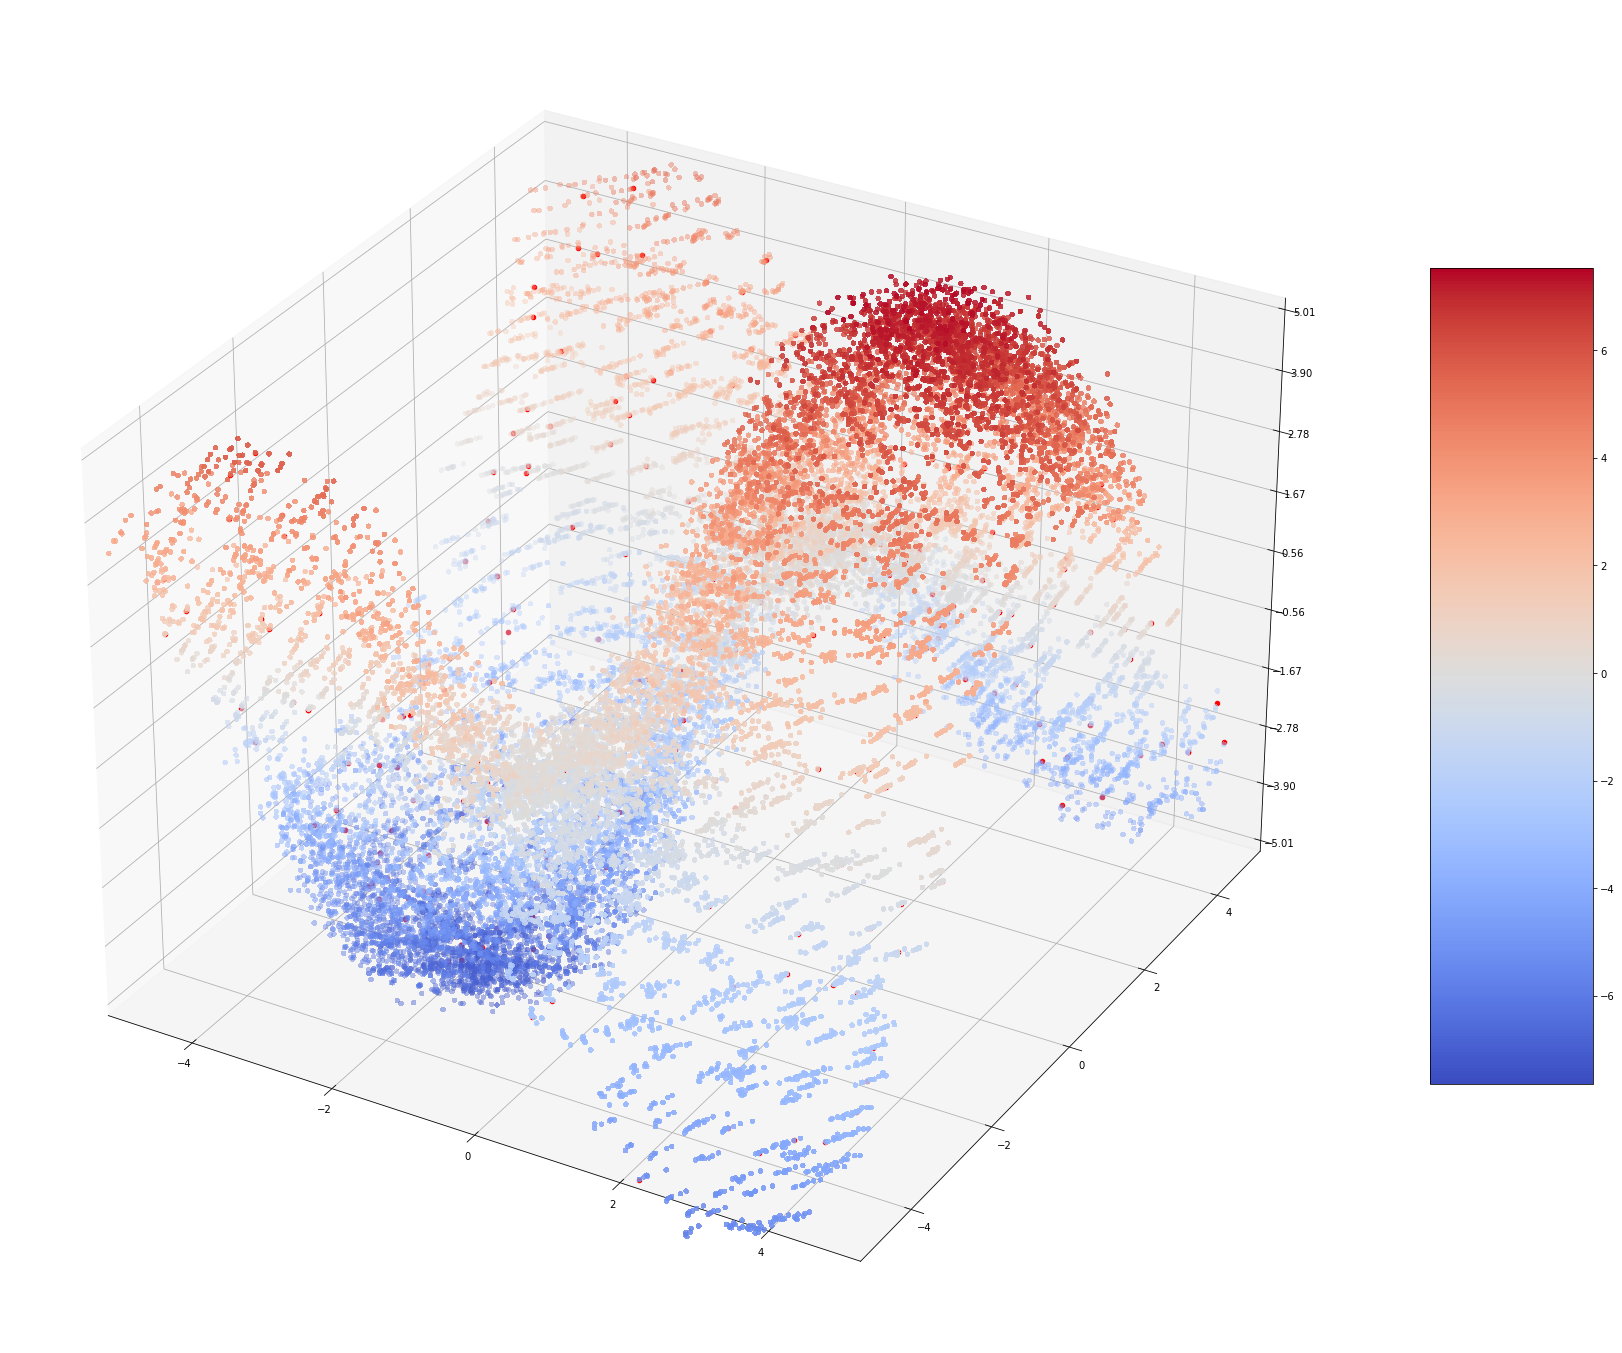

In [10]:
import time
# 隨機選 size 個點

# original_sample_points = [H[:,i] for i in sample_index]
reconstruct_sample_points_1 = []


fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(30, 30))


sub_x_all = []
sub_y_all = []
sub_z_all = []

start = time.process_time()
for index in tqdm(sample_index):

  # print(f"index:{index}")
  r = R[:, index]

  # print("r",r.shape)

  ax.scatter(*r, c="red")

  R_neighbors_project_1 = Affine_sub_space_modified( r, R, h=1.5, m=1)
  # print(np.linalg.norm(q-r))

  sub_x, sub_y, sub_z = R_neighbors_project_1

  reconstruct_sample_points_1.append(R_neighbors_project_1[:,0])

  # sub_plot = ax.scatter(sub_x, sub_y, sub_z, c="blue")
  
  sub_x_all.extend(sub_x)
  sub_y_all.extend(sub_y)
  sub_z_all.extend(sub_z)
print(f"{time.process_time() - start}")

reconstruc_surf = ax.scatter(sub_x_all, sub_y_all, sub_z_all, c=sub_z_all,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, 40)

# Add a color bar which maps values to colors.


ax.set_xlim(-5.01, 5.01)
ax.set_ylim(-5.01, 5.01)

# Customize the z axis.
ax.set_zlim(-5.01, 5.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{02f}.format(x)')

# Add a color bar which maps values to colors.
fig.colorbar(reconstruc_surf, shrink=0.5, aspect=5)
plt.show()
fig.savefig('Result.png')

In [11]:
from sklearn.decomposition import PCA

## From oracle point of view, compare reconstructed manifold with original manifold by sample poins.

In [13]:
reconstruct_sample_points_1 = np.array(reconstruct_sample_points_1)
error_MMLS_1 = LA.norm(H[:,sample_index].T-reconstruct_sample_points_1,axis=1)
E_MMLS_1 = np.power(error_MMLS_1, 2).mean()
print(f"E_MMLS_1 noisy sample:{E_MMLS_1}")

E_MMLS_1 noisy sample:0.11628923792199386


In [14]:
reconstruct_sample_points_2 = np.array(reconstruct_sample_points_2)
error_MMLS_2 = LA.norm(H[:,sample_index].T-reconstruct_sample_points_2,axis=1)
E_MMLS_2 = np.power(error_MMLS_2, 2).mean()
print(f"E_MMLS_2 noisy sample:{E_MMLS_2}")

E_MMLS_2 noisy sample:0.1567036055592473


In [15]:
start = time.process_time()
pca = PCA(n_components=2)
R_pca = pca.fit_transform(R.T)
R_proj = pca.inverse_transform(R_pca[sample_index])
print( time.process_time() - start)
pca_loss = LA.norm((H[:,sample_index].T - R_proj) ,axis=1)
P_MMLS = np.power(pca_loss, 2).mean()

print(f"pca_loss: {P_MMLS}")

0.016429000000002247
pca_loss: 5.738001799617737


# Clean sample assumption

  0%|          | 0/400 [00:00<?, ?it/s]/var/folders/5x/836ygdnj2yl_4txj_vrwx_740000gn/T/ipykernel_82288/1383172910.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  poly_coef, _, _, _ = np.linalg.lstsq(A, B)
100%|██████████| 400/400 [00:07<00:00, 50.66it/s]


7.981152000000002


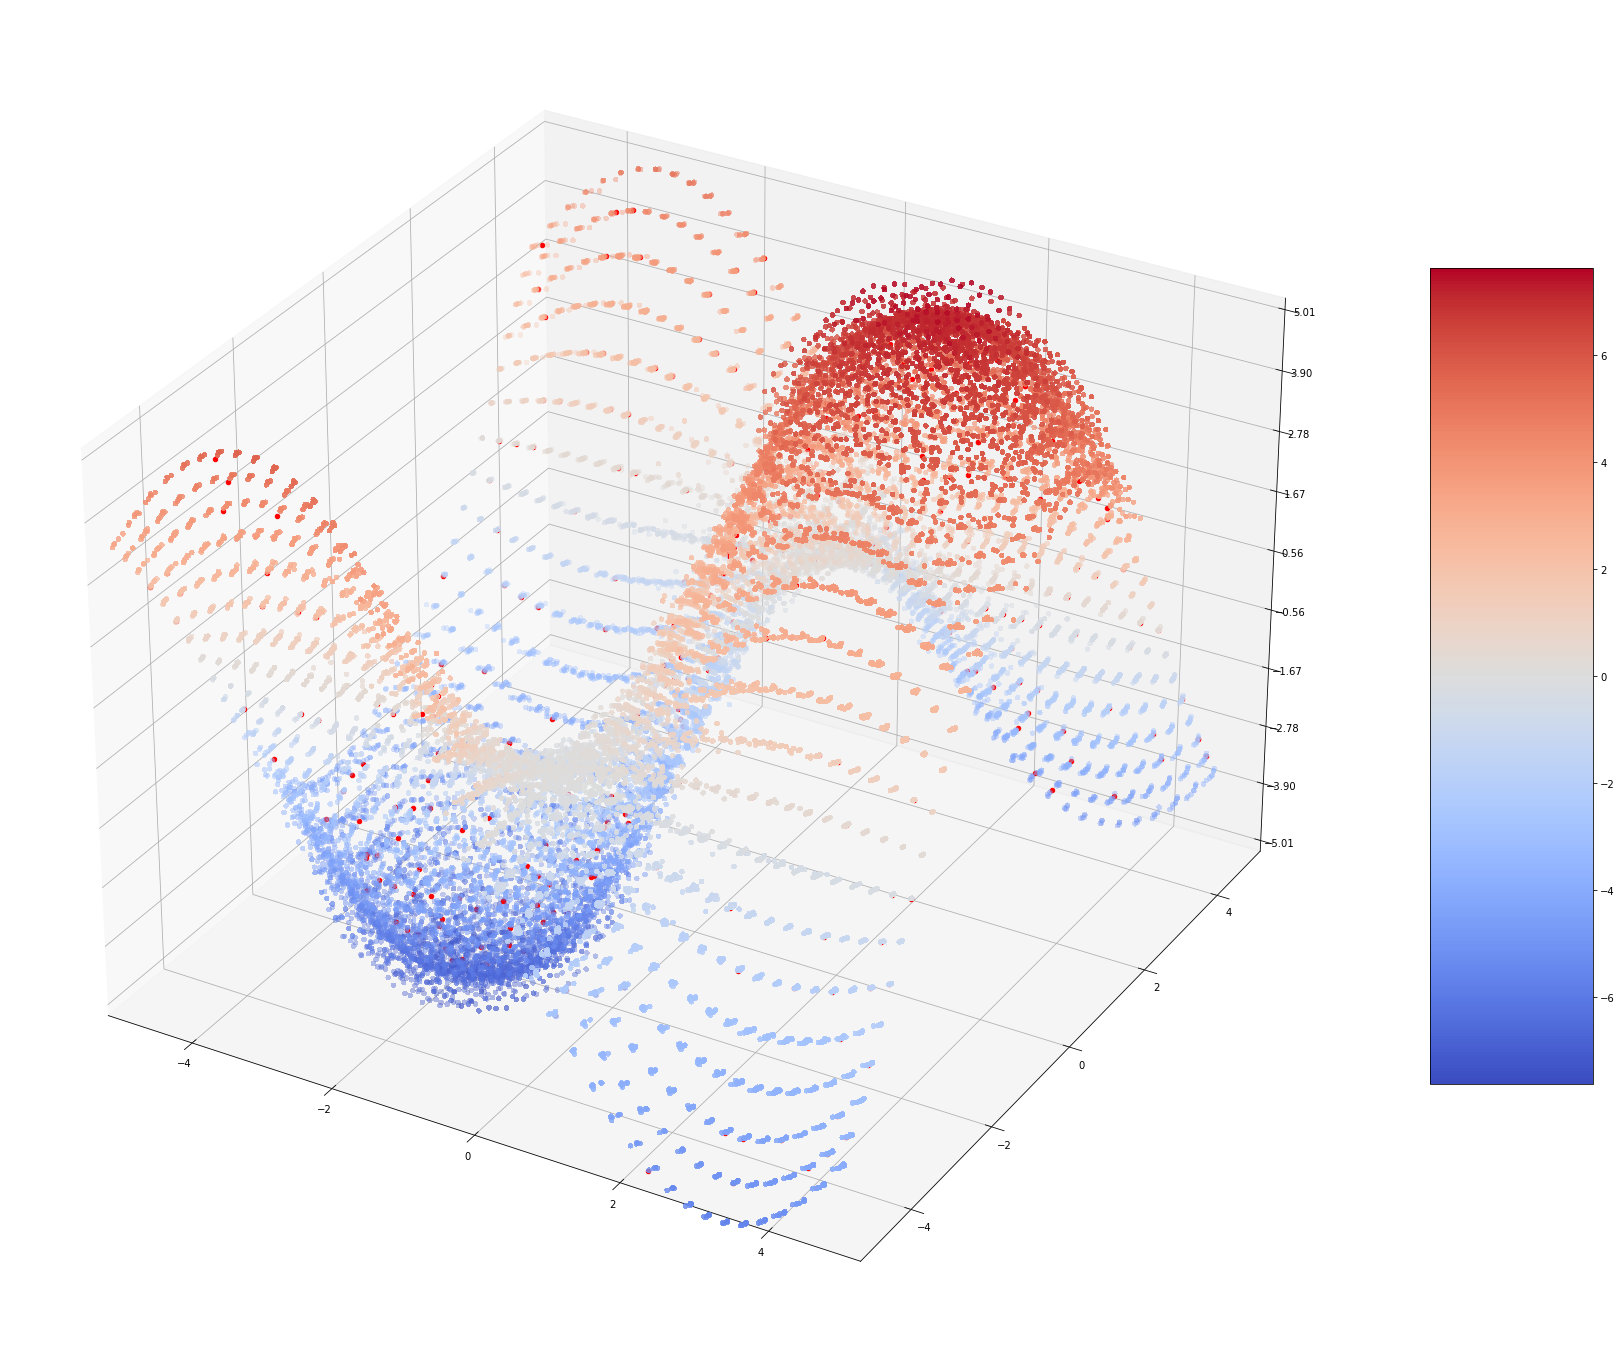

In [16]:
import time
# 隨機選 size 個點

# original_sample_points = [H[:,i] for i in sample_index]
reconstruct_sample_points_2 = []


fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(30, 30))


sub_x_all = []
sub_y_all = []
sub_z_all = []

start = time.process_time()
for index in tqdm(sample_index):

  # print(f"index:{index}")
  r = H[:, index]

  # print("r",r.shape)

  ax.scatter(*r, c="red")

  R_neighbors_project_2 = Affine_sub_space_modified( r, H, h=1.5, m=2)
  # print(np.linalg.norm(q-r))

  sub_x, sub_y, sub_z = R_neighbors_project_2

  reconstruct_sample_points_2.append(R_neighbors_project_2[:,0])

  # sub_plot = ax.scatter(sub_x, sub_y, sub_z, c="blue")
  
  sub_x_all.extend(sub_x)
  sub_y_all.extend(sub_y)
  sub_z_all.extend(sub_z)
print(f"{time.process_time() - start}")

reconstruc_surf = ax.scatter(sub_x_all, sub_y_all, sub_z_all, c=sub_z_all,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, 40)

# Add a color bar which maps values to colors.


ax.set_xlim(-5.01, 5.01)
ax.set_ylim(-5.01, 5.01)

# Customize the z axis.
ax.set_zlim(-5.01, 5.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{02f}.format(x)')

# Add a color bar which maps values to colors.
fig.colorbar(reconstruc_surf, shrink=0.5, aspect=5)
plt.show()
fig.savefig('Result.png')


  0%|          | 0/400 [00:00<?, ?it/s]/var/folders/5x/836ygdnj2yl_4txj_vrwx_740000gn/T/ipykernel_82288/1383172910.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  poly_coef, _, _, _ = np.linalg.lstsq(A, B)
100%|██████████| 400/400 [00:08<00:00, 48.51it/s]


8.242268000000003


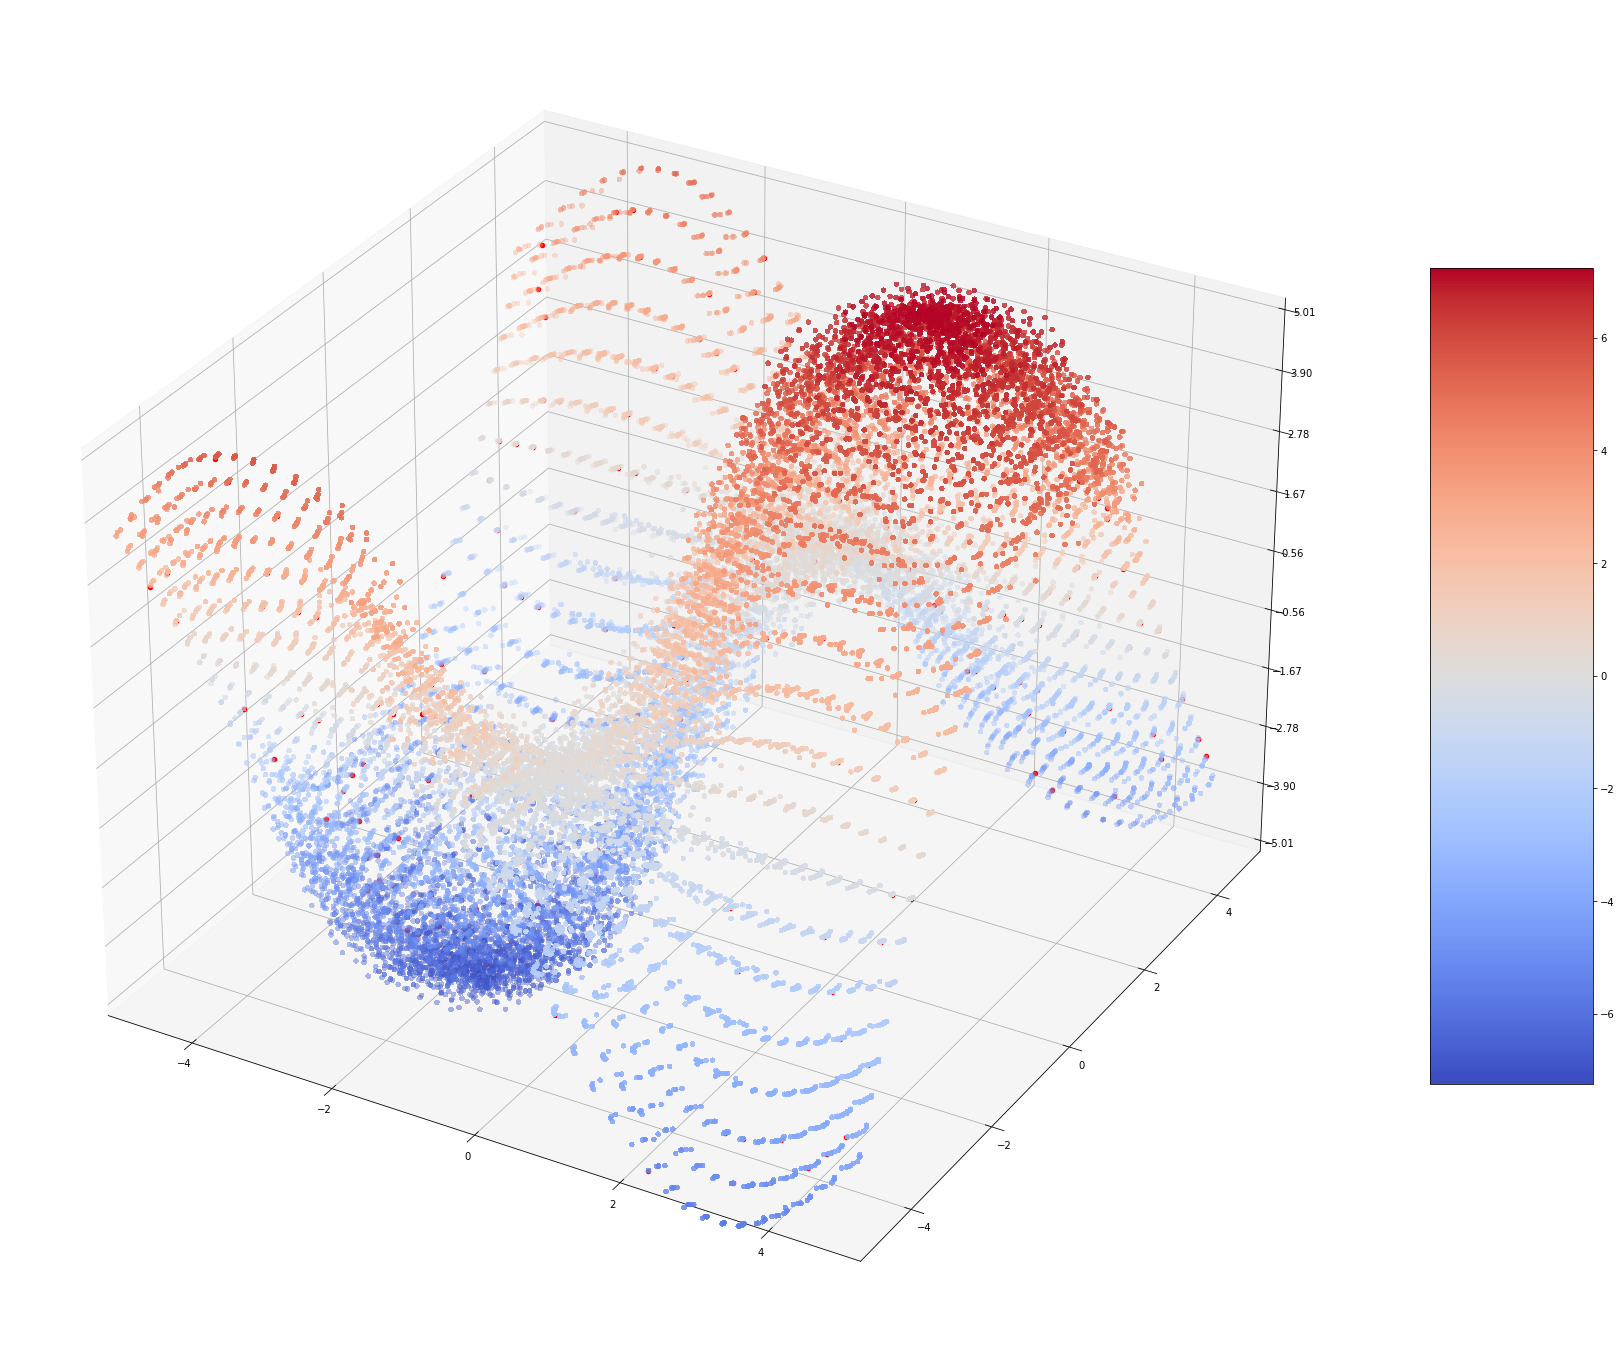

In [17]:
import time
# 隨機選 size 個點

# original_sample_points = [H[:,i] for i in sample_index]
reconstruct_sample_points_1 = []


fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(30, 30))


sub_x_all = []
sub_y_all = []
sub_z_all = []

start = time.process_time()
for index in tqdm(sample_index):

  # print(f"index:{index}")
  r = H[:, index]

  # print("r",r.shape)

  ax.scatter(*r, c="red")

  R_neighbors_project_1 = Affine_sub_space_modified( r, H, h=1.5, m=1)
  # print(np.linalg.norm(q-r))

  sub_x, sub_y, sub_z = R_neighbors_project_1

  reconstruct_sample_points_1.append(R_neighbors_project_1[:,0])

  # sub_plot = ax.scatter(sub_x, sub_y, sub_z, c="blue")
  
  sub_x_all.extend(sub_x)
  sub_y_all.extend(sub_y)
  sub_z_all.extend(sub_z)
print(f"{time.process_time() - start}")

reconstruc_surf = ax.scatter(sub_x_all, sub_y_all, sub_z_all, c=sub_z_all,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, 40)

# Add a color bar which maps values to colors.


ax.set_xlim(-5.01, 5.01)
ax.set_ylim(-5.01, 5.01)

# Customize the z axis.
ax.set_zlim(-5.01, 5.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{02f}.format(x)')

# Add a color bar which maps values to colors.
fig.colorbar(reconstruc_surf, shrink=0.5, aspect=5)
plt.show()
fig.savefig('Result.png')

In [18]:
reconstruct_sample_points_2 = np.array(reconstruct_sample_points_2)
error_MMLS_2 = LA.norm(H[:,sample_index].T-reconstruct_sample_points_2,axis=1)
E_MMLS_2 = np.power(error_MMLS_2, 2).mean()
print(f"E_MMLS_2 clean sample:{E_MMLS_2}")

E_MMLS_2 clean sample:0.06291879628378311


In [20]:
reconstruct_sample_points_1 = np.array(reconstruct_sample_points_1)
error_MMLS_1 = LA.norm(H[:,sample_index].T-reconstruct_sample_points_1,axis=1)
E_MMLS_1 = np.power(error_MMLS_1, 2).mean()
print(f"E_MMLS_1 clean sample:{E_MMLS_1}")

E_MMLS_1 clean sample:7.86406006783186e-05


In [21]:
start = time.process_time()

pca = PCA(n_components=2)
H_pca = pca.fit_transform(H.T)
H_proj = pca.inverse_transform(H_pca[sample_index])

print(f"{time.process_time() - start}")
pca_loss = LA.norm(H[:,sample_index].T - H_proj, axis=1)
P_loss = np.power(pca_loss, 2).mean()
print(f"pca_loss: {P_loss}")

0.012264999999999304
pca_loss: 5.6594086906101
